In [4]:
import regex as re
import numpy as np
import pandas as pd 
import datetime
import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import matplotlib.pyplot as plt

In [5]:
# retrieving file with collected Facebook data
fb_data = pd.read_csv('facebook_covid_posts_updated.csv', encoding = "latin1")
fb_data.head(2)

,Unnamed: 0,Unnamed: 0.1,News Org.,Post's Title,Added link,Time Posted,Posted By,# Shares,# Total Reactions,# Like,# Love,# Haha,# Wow,# Sad,# Angry,# Comments,Post's Text
0,0,1,CNN,Thousands of meals meant for an Ohio sports fe...,https://cnn.it/2VUDfSU,2020-03-07,CNN,3630.0,18595.0,13710.0,4736.0,8.0,94.0,44.0,3.0,272.0,Instead of throwing it away because of a chang...
1,1,2,CNN,"In the middle of a coronavirus outbreak, peopl...",https://cnn.it/330y3y0,2020-03-07,CNN,189.0,874.0,595.0,10.0,12.0,80.0,172.0,5.0,153.0,There's a new reality beginning to form in the...


In [6]:
fb_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'News Org.', 'Post's Title', 'Added link',
       'Time Posted', 'Posted By', '# Shares', '# Total Reactions', '# Like',
       '# Love', '# Haha', '# Wow', '# Sad', '# Angry', '# Comments',
       'Post's Text'],
      dtype='object')

In [7]:
fb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4962 entries, 0 to 4961
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         4962 non-null   int64  
 1   Unnamed: 0.1       4962 non-null   int64  
 2   News Org.          4962 non-null   object 
 3   Post's Title       4772 non-null   object 
 4   Added link         4962 non-null   object 
 5   Time Posted        4962 non-null   object 
 6   Posted By          4962 non-null   object 
 7   # Shares           4962 non-null   float64
 8   # Total Reactions  4962 non-null   float64
 9   # Like             4962 non-null   float64
 10  # Love             4962 non-null   float64
 11  # Haha             4962 non-null   float64
 12  # Wow              4962 non-null   float64
 13  # Sad              4962 non-null   float64
 14  # Angry            4962 non-null   float64
 15  # Comments         4962 non-null   float64
 16  Post's Text        4557 

In [8]:
data=[fb_data['News Org.'], fb_data['Time Posted'], fb_data["Post's Title"], fb_data["Post's Text"],
      fb_data['# Shares'], fb_data['# Comments'], fb_data['# Total Reactions'], fb_data["# Like"], 
      fb_data['# Love'], fb_data['# Haha'], fb_data['# Wow'], fb_data["# Sad"], fb_data['# Angry']]
      
headers =  ['organization', 'date', 'title', 'post', 'shares', 'comments', 'total_reactions', 'like', 'love',
             'haha', 'wow', 'sad', 'angry']       
df1 = pd.concat(data, keys=headers, axis=1, )   
df1.head()

,organization,date,title,post,shares,comments,total_reactions,like,love,haha,wow,sad,angry
0,CNN,2020-03-07,Thousands of meals meant for an Ohio sports fe...,Instead of throwing it away because of a chang...,3630.0,272.0,18595.0,13710.0,4736.0,8.0,94.0,44.0,3.0
1,CNN,2020-03-07,"In the middle of a coronavirus outbreak, peopl...",There's a new reality beginning to form in the...,189.0,153.0,874.0,595.0,10.0,12.0,80.0,172.0,5.0
2,CNN,2020-03-07,Coronavirus spreads as outbreak clusters grow ...,The number of US coronavirus cases more than t...,473.0,372.0,1653.0,1010.0,11.0,16.0,190.0,416.0,10.0
3,CNN,2020-03-07,Adoptions from China are being held up by the ...,Many families in the US were just days or week...,6400.0,1576.0,24250.0,13370.0,3659.0,94.0,381.0,6661.0,85.0
4,CNN,2020-03-06,Anderson Cooper Full Circle - CNN,Weâll speak with Amir Medawar who pushed to ...,30.0,58.0,278.0,173.0,3.0,0.0,19.0,79.0,4.0


In [9]:
df1['CNN'] = df1['organization'].apply(lambda x: 1 if x == 'CNN' else 0)



df1.head(15)

,organization,date,title,post,shares,comments,total_reactions,like,love,haha,wow,sad,angry,CNN
0,CNN,2020-03-07,Thousands of meals meant for an Ohio sports fe...,Instead of throwing it away because of a chang...,3630.0,272.0,18595.0,13710.0,4736.0,8.0,94.0,44.0,3.0,1
1,CNN,2020-03-07,"In the middle of a coronavirus outbreak, peopl...",There's a new reality beginning to form in the...,189.0,153.0,874.0,595.0,10.0,12.0,80.0,172.0,5.0,1
2,CNN,2020-03-07,Coronavirus spreads as outbreak clusters grow ...,The number of US coronavirus cases more than t...,473.0,372.0,1653.0,1010.0,11.0,16.0,190.0,416.0,10.0,1
3,CNN,2020-03-07,Adoptions from China are being held up by the ...,Many families in the US were just days or week...,6400.0,1576.0,24250.0,13370.0,3659.0,94.0,381.0,6661.0,85.0,1
4,CNN,2020-03-06,Anderson Cooper Full Circle - CNN,Weâll speak with Amir Medawar who pushed to ...,30.0,58.0,278.0,173.0,3.0,0.0,19.0,79.0,4.0,1
5,CNN,2020-03-06,WHO says 'this is not a drill' as coronavirus ...,"""This is not a drill. This is not the time to ...",1217.0,412.0,3078.0,2425.0,27.0,56.0,254.0,256.0,60.0,1
6,CNN,2020-03-06,"Here's who needs to wear a face mask, and who ...",The advice on whether people should wear masks...,229.0,146.0,410.0,383.0,1.0,16.0,7.0,0.0,3.0,1
7,CNN,2020-03-06,Coronavirus outbreak leaves busy tourist attra...,Public places that are usually packed with vis...,265.0,111.0,1270.0,794.0,8.0,16.0,161.0,286.0,5.0,1
8,CNN,2020-03-06,Drastic measures and closures as the world rea...,"There are now more than 90,000 cases of corona...",23327.0,1927.0,47095.0,37538.0,951.0,249.0,1766.0,6350.0,241.0,1
9,CNN,2020-03-05,US tries to identify people in contact with in...,US officials are trying to identify people who...,534.0,267.0,1458.0,750.0,7.0,36.0,415.0,228.0,22.0,1


In [10]:
# removing rows with no posts
df1 = df1[df1['post'].notna()]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4557 entries, 0 to 4961
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   organization     4557 non-null   object 
 1   date             4557 non-null   object 
 2   title            4367 non-null   object 
 3   post             4557 non-null   object 
 4   shares           4557 non-null   float64
 5   comments         4557 non-null   float64
 6   total_reactions  4557 non-null   float64
 7   like             4557 non-null   float64
 8   love             4557 non-null   float64
 9   haha             4557 non-null   float64
 10  wow              4557 non-null   float64
 11  sad              4557 non-null   float64
 12  angry            4557 non-null   float64
 13  CNN              4557 non-null   int64  
dtypes: float64(9), int64(1), object(4)
memory usage: 534.0+ KB


In [11]:
df1.fillna("",inplace=True)

In [12]:
# Converting date to datetime format and extracting year and month only (omitting a "day" information)
df1['yearMonth'] = pd.to_datetime(df1['date'])
df1['yearMonth'] = df1['yearMonth'].dt.strftime('%Y-%m-%d')
df1.head(2)

,organization,date,title,post,shares,comments,total_reactions,like,love,haha,wow,sad,angry,CNN,yearMonth
0,CNN,2020-03-07,Thousands of meals meant for an Ohio sports fe...,Instead of throwing it away because of a chang...,3630.0,272.0,18595.0,13710.0,4736.0,8.0,94.0,44.0,3.0,1,2020-03-07
1,CNN,2020-03-07,"In the middle of a coronavirus outbreak, peopl...",There's a new reality beginning to form in the...,189.0,153.0,874.0,595.0,10.0,12.0,80.0,172.0,5.0,1,2020-03-07


In [13]:
monthlyPosts = df1.groupby(['yearMonth', 'organization']).size().reset_index().rename(columns={0: 'postsCount'})
monthlyPosts = monthlyPosts.sort_values(['yearMonth', 'postsCount'], ascending = (True, False))
monthlyPosts

,yearMonth,organization,postsCount
2,2020-03-01,USAToday,3
0,2020-03-01,CNN,2
1,2020-03-01,NYT,2
3,2020-03-01,WSJ,1
7,2020-03-02,WSJ,6
...,...,...,...
1041,2021-04-09,USAToday,3
1046,2021-04-10,WSJ,12
1043,2021-04-10,ABCNews,5
1044,2021-04-10,TheGuardian,2


In [14]:
# Creating a pivot table with Covid-related FB post per organization per month
postCountsPivot=pd.pivot_table(monthlyPosts,index=['organization'],columns='yearMonth',values='postsCount',aggfunc=sum,fill_value=0)
postCountsPivot

yearMonth,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,...,2021-03-29,2021-03-30,2021-03-31,2021-04-01,2021-04-02,2021-04-03,2021-04-07,2021-04-08,2021-04-09,2021-04-10
organization,,,,,,,,,,,,,,,,,,,,,
ABCNews,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,7,4,0,2,7,5
BBC,0,0,0,1,1,3,2,0,0,0,...,1,5,0,0,0,0,0,0,0,0
CNN,2,5,7,7,16,5,4,0,7,7,...,9,6,0,0,0,0,0,0,0,0
FOX,0,0,0,0,0,4,2,0,0,0,...,0,1,0,0,0,0,0,0,0,0
NBC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NYT,2,4,7,6,3,3,7,0,0,5,...,9,8,0,0,0,0,0,0,0,0
TheGuardian,0,0,1,3,2,2,0,0,1,5,...,0,1,2,1,2,2,0,0,0,2
USAToday,3,2,3,2,1,2,2,5,2,7,...,0,3,3,5,6,0,1,4,3,1
WASH,0,0,0,0,0,2,3,0,0,0,...,0,1,0,0,0,0,0,0,0,0


<AxesSubplot:ylabel='organization'>

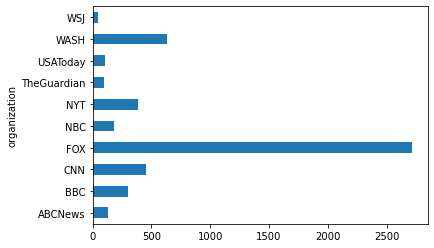

In [15]:
# average angry by organization
angry = df1.groupby('organization')['angry'].mean()
#angry
angry.plot.barh()

<AxesSubplot:ylabel='organization'>

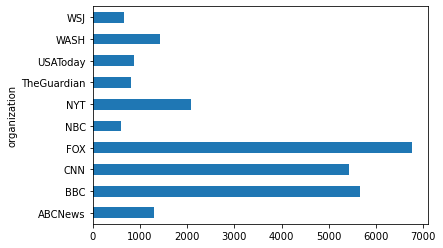

In [16]:
# average love by organization
love = df1.groupby('organization')['like'].mean()
#love
love.plot.barh()

<AxesSubplot:ylabel='organization'>

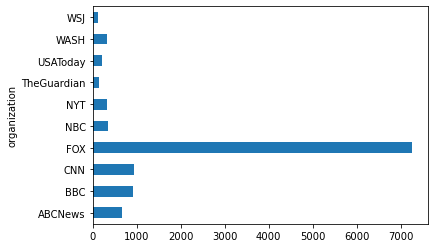

In [17]:
# average number of comments by organization
comments = df1.groupby('organization')['comments'].mean()
#comments
comments.plot.barh()

<AxesSubplot:ylabel='organization'>

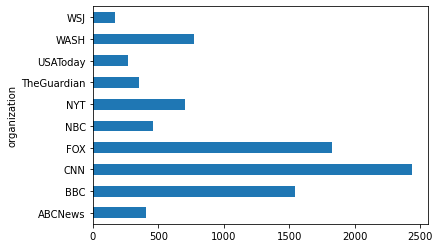

In [18]:
# average number of shares by organization
shares = df1.groupby('organization')['shares'].mean()
#shares
shares.plot.barh()

<AxesSubplot:ylabel='organization'>

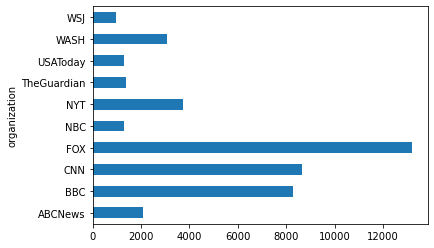

In [19]:
# average total reactions by organization
reactions = df1.groupby('organization')['total_reactions'].mean()
#reactions
reactions.plot.barh()

<AxesSubplot:xlabel='date'>

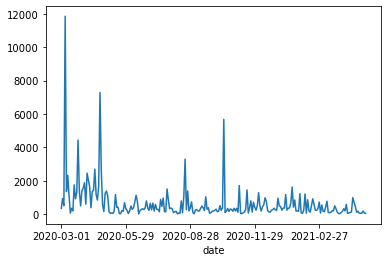

In [20]:
# average shares over time
shares = df1.groupby('date')['shares'].mean()
#print(shares)
shares.plot.line()

<AxesSubplot:xlabel='date'>

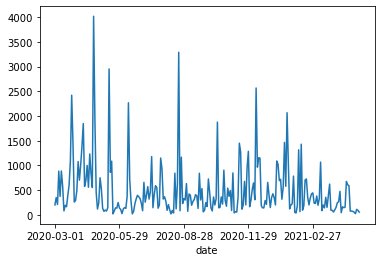

In [21]:
# average commments over time
commments = df1.groupby('date')['comments'].mean()
#print(commments)
commments.plot.line()

<AxesSubplot:xlabel='date'>

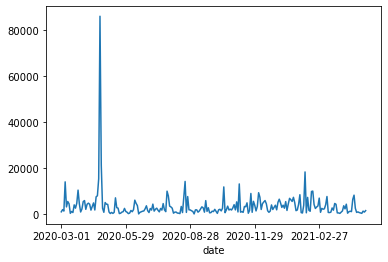

In [22]:
# average reactions over time
reactions = df1.groupby('date')['total_reactions'].mean()
#print(reactions)
reactions.plot.line()